In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
# Generate synthetic telecom traffic data
np.random.seed(42) #number isn't too important
dates = pd.date_range(start='2023-01-01', end='2023-12-31', freq='h')
n_samples = len(dates)
# Create realistic traffic patterns
hour = dates.hour
day_of_week = dates.dayofweek
day_of_year = dates.dayofyear
# Base traffic with daily and weekly patterns
base_traffic = (
    50 + # Base level
    20 * np.sin(2 * np.pi * hour / 24) + # Daily pattern
    10 * np.sin(2 * np.pi * day_of_week / 7) + # Weekly pattern
    5 * np.sin(2 * np.pi * day_of_year / 365) + # Annual pattern
    np.random.normal(0, 5, n_samples) # Noise
)
# Add business hours boost
business_hours = (hour >= 8) & (hour <= 19) & (day_of_week < 5) #The
# numbers were 9-5 to represent business hours im extending it from 8 to
# 7
base_traffic += business_hours * 15
# Create DataFrame
traffic_data = pd.DataFrame({
    'timestamp': dates,
    'hour': hour,
    'day_of_week': day_of_week,
    'is_weekend': day_of_week >= 5,
    'is_business_hours': business_hours,
    'traffic_gbps': np.maximum(base_traffic, 0) # Ensure non-negative
})

In [6]:
# Feature engineering, doing basic null value removals.
traffic_data['traffic_lag_1h'] = traffic_data['traffic_gbps'].shift(1)
traffic_data['traffic_lag_24h'] = traffic_data['traffic_gbps'].shift(24)
traffic_data['traffic_rolling_7d'] = traffic_data['traffic_gbps'].rolling(
 window=24*7, center=True
).mean()
# Remove rows with NaN values
traffic_data = traffic_data.dropna()
print("Dataset shape:", traffic_data.shape)
print("\nFirst few rows:")
print(traffic_data.head())
# Visualize the data
plt.figure(figsize=(15, 8))

Dataset shape: (8570, 9)

First few rows:
             timestamp  hour  day_of_week  is_weekend  is_business_hours  \
84 2023-01-04 12:00:00    12            2       False               True   
85 2023-01-04 13:00:00    13            2       False               True   
86 2023-01-04 14:00:00    14            2       False               True   
87 2023-01-04 15:00:00    15            2       False               True   
88 2023-01-04 16:00:00    16            2       False               True   

    traffic_gbps  traffic_lag_1h  traffic_lag_24h  traffic_rolling_7d  
84     71.050823       77.678321        70.680542           55.505387  
85     67.408125       71.050823        66.971737           55.486874  
86     69.670302       67.408125        57.544738           55.472130  
87     62.594911       69.670302        52.953244           55.429953  
88     55.123982       62.594911        59.818534           55.363918  


<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

(array([19362., 19363., 19364., 19365., 19366., 19367., 19368.]),
 [Text(19362.0, 0, '2023-01-05'),
  Text(19363.0, 0, '2023-01-06'),
  Text(19364.0, 0, '2023-01-07'),
  Text(19365.0, 0, '2023-01-08'),
  Text(19366.0, 0, '2023-01-09'),
  Text(19367.0, 0, '2023-01-10'),
  Text(19368.0, 0, '2023-01-11')])

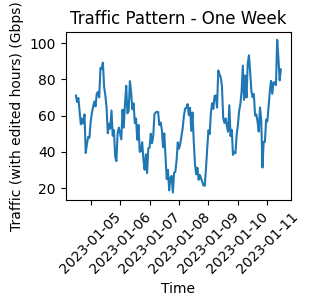

In [7]:
plt.subplot(2, 2, 1)
plt.plot(traffic_data['timestamp'][:24*7],
traffic_data['traffic_gbps'][:24*7])
plt.title('Traffic Pattern - One Week')
plt.xlabel('Time')
plt.ylabel('Traffic (with edited hours) (Gbps)')
plt.xticks(rotation=45)

Text(0, 0.5, 'Average Traffic (Gbps)')

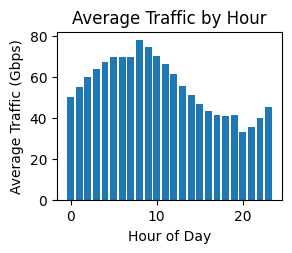

In [9]:
plt.subplot(2, 2, 2) #note that business hours isn't here.
hourly_avg = traffic_data.groupby('hour')['traffic_gbps'].mean()
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Traffic by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic (Gbps)')

Text(0, 0.5, 'Average Traffic (Gbps)')

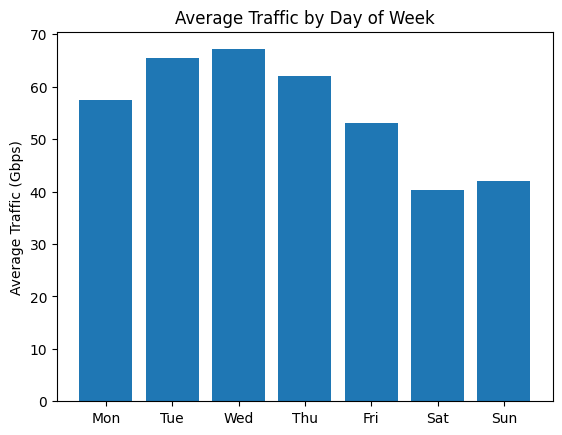

In [18]:
plt.subplot(1, 1, 1) #changing these values adjusts the graph size
daily_avg = traffic_data.groupby('day_of_week')['traffic_gbps'].mean()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] #sunday and
# saturday are lower cause less business
plt.bar(days, daily_avg.values)
plt.title('Average Traffic by Day of Week')
plt.ylabel('Average Traffic (Gbps)')

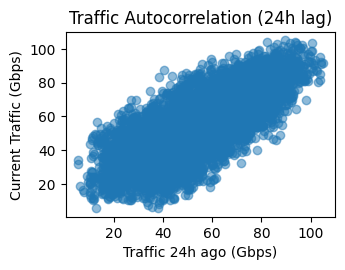

In [12]:
plt.subplot(2, 2, 4)
plt.scatter(traffic_data['traffic_lag_24h'],
traffic_data['traffic_gbps'], alpha=0.5)
plt.title('Traffic Autocorrelation (24h lag)')
plt.xlabel('Traffic 24h ago (Gbps)')
plt.ylabel('Current Traffic (Gbps)')
plt.tight_layout()
plt.show()

In [13]:
# Prepare features and target
feature_columns = [
 'hour', 'day_of_week', 'is_weekend', 'is_business_hours',
 'traffic_lag_1h', 'traffic_lag_24h', 'traffic_rolling_7d'
]
X = traffic_data[feature_columns]
y = traffic_data['traffic_gbps']
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
 X, y, test_size=0.2, random_state=42, shuffle=False
)
# Train Random Forest model
rf_model = RandomForestRegressor(
 n_estimators=100,
 max_depth=10,
 random_state=42,
 n_jobs=-1
)


In [19]:
rf_model.fit(X_train, y_train)
# Make predictions
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)
# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
print(f"\nModel Performance:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training R²: {train_r2:.3f}")
print(f"Testing R²: {test_r2:.3f}")
# Feature importance
feature_importance = pd.DataFrame({
 'feature': feature_columns,
 'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)
print(f"\nFeature Importance:")
print(feature_importance)


Model Performance:
Training MSE: 17.77
Testing MSE: 35.46
Training R²: 0.945
Testing R²: 0.889

Feature Importance:
              feature  importance
4      traffic_lag_1h    0.818457
0                hour    0.075858
5     traffic_lag_24h    0.037871
1         day_of_week    0.027523
6  traffic_rolling_7d    0.023353
3   is_business_hours    0.014016
2          is_weekend    0.002923


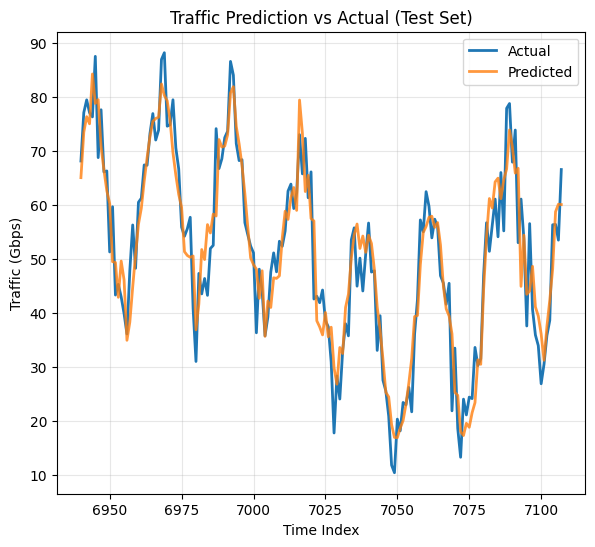

In [20]:
# Plot predictions vs actual
plt.figure(figsize=(15, 6))
test_indices = X_test.index[:168] # Show one week of test data
plt.subplot(1, 2, 1)
plt.plot(test_indices, y_test.loc[test_indices], label='Actual',
linewidth=2)
plt.plot(test_indices, y_pred_test[:len(test_indices)],
 label='Predicted', linewidth=2, alpha=0.8)
plt.title('Traffic Prediction vs Actual (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Traffic (Gbps)')
plt.legend()
plt.grid(True, alpha=0.3)